In [1]:
import os
import imageio
import numpy as np
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
import shutil
# tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
!nvidia-smi

Tue Jan 11 14:20:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
class Helpers():
    
    @staticmethod
    def normalize(images):
        return np.array(images)/127.5-1.0
    
    @staticmethod
    def unnormalize(images):
        return (0.5*np.array(images)+0.5)*255
    
    @staticmethod
    def resize(image, size):
        return np.array(cv2.resize(image, size))
    
    @staticmethod
    def split_images(image, is_testing):
        image = imageio.imread(image).astype(np.float)
        _, width, _ = image.shape
        half_width = int(width/2)
        source_image = image[:, half_width:, :]
        destination_image = image[:, :half_width, :]
        source_image = Helpers.resize(source_image, (IMAGE_SIZE, IMAGE_SIZE))
        destination_image = Helpers.resize(destination_image, (IMAGE_SIZE, IMAGE_SIZE))
        if not is_testing and np.random.random() > 0.5:
            source_image = np.fliplr(source_image)
            destination_image = np.fliplr(destination_image)
        return source_image, destination_image
    
    @staticmethod
    def new_dir(path):
        shutil.rmtree(path, ignore_errors=True)
        os.makedirs(path, exist_ok=True)
        
    @staticmethod
    def archive_output():
        shutil.make_archive("output", "zip", "./output")
        
    @staticmethod
    def image_pairs(batch, is_testing):
        source_images, destination_images = [], []
        for image_path in batch:
            source_image, destination_image = Helpers.split_images(image_path, is_testing)
            source_images.append(source_image)
            destination_images.append(destination_image)
        return source_images, destination_images

In [4]:
class DataLoader():
    
    def __init__(self, dataset_name="pix2pix-depth"):
        self.dataset_name = dataset_name
        base_path = BASE_INPUT_PATH + self.dataset_name + "/" + self.dataset_name + "/"
        self.training_path = base_path + "training/"
        self.validation_path = base_path + "validation/"
        self.testing_path = base_path + "testing/"
        self.testing_raw_path = base_path + "testing_raw/"

    def load_random_data(self, data_size, is_testing=False):
        paths = glob(self.training_path+"*") if is_testing else glob(self.testing_path+"*")
        source_images, destination_images = Helpers.image_pairs(np.random.choice(paths, size=data_size), is_testing)
        return Helpers.normalize(source_images), Helpers.normalize(destination_images)

    def yield_batch(self, batch_size, is_testing=False):
        paths = glob(self.training_path+"*") if is_testing else glob(self.validation_path+"*")
        for i in range(int(len(paths)/batch_size)-1):
            batch = paths[i*batch_size:(i+1)*batch_size]
            source_images, destination_images = Helpers.image_pairs(batch, is_testing)
            yield Helpers.normalize(source_images), Helpers.normalize(destination_images)

In [5]:
# Model architecture from: https://phillipi.github.io/pix2pix/
class Pix2Pix(): 
    
    def __init__(self):
        Helpers.new_dir(BASE_OUTPUT_PATH + "training/")
        Helpers.new_dir(BASE_OUTPUT_PATH + "training/losses/")

        self.image_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
        self.data_loader = DataLoader()

        patch = int(IMAGE_SIZE / 2**4)
        self.disc_patch = (patch, patch, 1)

        self.generator_filters = 64
        self.discriminator_filters = 64
        
        optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1)

        self.discriminator = self.discriminator()
        self.discriminator.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
        self.generator = self.generator()

        source_image = tf.keras.layers.Input(shape=self.image_shape)
        destination_image = tf.keras.layers.Input(shape=self.image_shape)
        generated_image = self.generator(destination_image)

        self.discriminator.trainable = False
        valid = self.discriminator([generated_image, destination_image])
        self.combined = tf.keras.models.Model(inputs=[source_image, destination_image], outputs=[valid, generated_image])
        self.combined.compile(loss=["mse", "mae"], loss_weights=[1, 100], optimizer=optimizer)
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer,
                                         discriminator_optimizer=optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)
        
        
        
    def generator(self):
        def conv2d(layer_input, filters, bn=True):
            downsample = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(layer_input)
            downsample = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU_ALPHA)(downsample)
            if bn:
                downsample = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(downsample)
            return downsample

        def deconv2d(layer_input, skip_input, filters, dropout_rate=0):
            upsample = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            upsample = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=1, padding="same", activation="relu")(upsample)
            if dropout_rate:
                upsample = tf.keras.layers.Dropout(dropout_rate)(upsample)
            upsample = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(upsample)
            upsample = tf.keras.layers.Concatenate()([upsample, skip_input])
            return upsample

        downsample_0 = tf.keras.layers.Input(shape=self.image_shape)
        downsample_1 = conv2d(downsample_0, self.generator_filters, bn=False)
        downsample_2 = conv2d(downsample_1, self.generator_filters*2)
        downsample_3 = conv2d(downsample_2, self.generator_filters*4)
        downsample_4 = conv2d(downsample_3, self.generator_filters*8)
        downsample_5 = conv2d(downsample_4, self.generator_filters*8)
        downsample_6 = conv2d(downsample_5, self.generator_filters*8)
        downsample_7 = conv2d(downsample_6, self.generator_filters*8)

        upsample_1 = deconv2d(downsample_7, downsample_6, self.generator_filters*8)
        upsample_2 = deconv2d(upsample_1, downsample_5, self.generator_filters*8)
        upsample_3 = deconv2d(upsample_2, downsample_4, self.generator_filters*8)
        upsample_4 = deconv2d(upsample_3, downsample_3, self.generator_filters*4)
        upsample_5 = deconv2d(upsample_4, downsample_2, self.generator_filters*2)
        upsample_6 = deconv2d(upsample_5, downsample_1, self.generator_filters)
        upsample_7 = tf.keras.layers.UpSampling2D(size=2)(upsample_6)
        
        output_image = tf.keras.layers.Conv2D(IMAGE_CHANNELS, kernel_size=4, strides=1, padding="same", activation="tanh")(upsample_7)
        return tf.keras.models.Model(downsample_0, output_image)

    def discriminator(self):
        def discriminator_layer(layer_input, filters, bn=True):
            discriminator_layer = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(layer_input)
            discriminator_layer = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU_ALPHA)(discriminator_layer)
            if bn:
                discriminator_layer = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(discriminator_layer)
            return discriminator_layer

        source_image = tf.keras.layers.Input(shape=self.image_shape)
        destination_image = tf.keras.layers.Input(shape=self.image_shape)
        combined_images = tf.keras.layers.Concatenate(axis=-1)([source_image, destination_image])
        discriminator_layer_1 = discriminator_layer(combined_images, self.discriminator_filters, bn=False)
        discriminator_layer_2 = discriminator_layer(discriminator_layer_1, self.discriminator_filters*2)
        discriminator_layer_3 = discriminator_layer(discriminator_layer_2, self.discriminator_filters*4)
        discriminator_layer_4 = discriminator_layer(discriminator_layer_3, self.discriminator_filters*8)
        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding="same")(discriminator_layer_4)
        return tf.keras.models.Model([source_image, destination_image], validity)
        
    def preview_training_progress(self, epoch, size=3):
        def preview_outputs(epoch, size):
            source_images, destination_images = self.data_loader.load_random_data(size, is_testing=True)
            generated_images = self.generator.predict(destination_images)
            grid_image = None
            for i in range(size):
                row = Helpers.unnormalize(np.concatenate([destination_images[i], generated_images[i], source_images[i]], axis=1))
                if grid_image is None:
                    grid_image = row
                else:
                    grid_image = np.concatenate([grid_image, row], axis=0)
            plt.imshow(grid_image/255.0)
            plt.show()
            plt.close()
            grid_image = cv2.cvtColor(np.float32(grid_image), cv2.COLOR_RGB2BGR)
            cv2.imwrite(BASE_OUTPUT_PATH + "training/ " + str(epoch) + ".png", grid_image)
            
        def preview_losses():
            def plot(title, data):
                plt.plot(data, alpha=0.6)
                plt.title(title + "_" + str(i))
                plt.savefig(BASE_OUTPUT_PATH + "training/losses/" + title + "_" + str(i) + ".png")
                plt.close()
            for i, d in enumerate(self.d_losses):
                plot("discriminator", d)
            for i, g in enumerate(self.g_losses):
                plot("generator", g)
                
        preview_outputs(epoch, size)
        #preview_losses()

    def train(self):
#         checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
        valid = np.ones((BATCH_SIZE,) + self.disc_patch)
        fake = np.zeros((BATCH_SIZE,) + self.disc_patch)
        self.d_losses = []
        self.g_losses = []
        self.preview_training_progress(0)
        for epoch in range(EPOCHS):
            filename2 = './training_checkpoints/model_%06d.h5' % (epoch+1)
            epoch_d_losses = []
            epoch_g_losses = []
            for iteration, (source_images, destination_images) in enumerate(self.data_loader.yield_batch(BATCH_SIZE)):
                generated_images = self.generator.predict(destination_images)
                d_loss_real = self.discriminator.train_on_batch([source_images, destination_images], valid)
                d_loss_fake = self.discriminator.train_on_batch([generated_images, destination_images], fake)
                d_losses = 0.5 * np.add(d_loss_real, d_loss_fake)
                g_losses = self.combined.train_on_batch([source_images, destination_images], [valid, source_images])
                epoch_d_losses.append(d_losses)
                epoch_g_losses.append(g_losses)
                print("\repoch: " + str(epoch) 
                      +", iteration: "+ str(iteration) 
                      + ", d_losses: " + str(d_losses) 
                      + ", g_losses: " + str(g_losses)
                      , sep=" ", end=" ", flush=True)
            self.d_losses.append(np.average(epoch_d_losses, axis=0))
            self.g_losses.append(np.average(epoch_g_losses, axis=0))
            self.preview_training_progress(epoch)
#             self.checkpoint.save(file_prefix=self.checkpoint_prefix)
            
            self.generator.save(filename2)
        
    def test(self):
        image_paths = glob(self.data_loader.testing_raw_path+"*")
        for image_path in image_paths:
            image = np.array(imageio.imread(image_path))
            image_normalized = Helpers.normalize(image)
            generated_batch = self.generator.predict(np.array([image_normalized]))
            concat = Helpers.unnormalize(np.concatenate([image_normalized, generated_batch[0]], axis=1))
            cv2.imwrite(BASE_OUTPUT_PATH+os.path.basename(image_path), cv2.cvtColor(np.float32(concat), cv2.COLOR_RGB2BGR))

In [6]:
BASE_INPUT_PATH = "../input/pix2pix-depth/" 
BASE_OUTPUT_PATH = "./output/"


IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
LEARNING_RATE = 0.00015
BETA_1 = 0.5
LEAKY_RELU_ALPHA = 0.2
BN_MOMENTUM = 0.8
EPOCHS = 50
BATCH_SIZE = 32

gan = Pix2Pix()
# gan.train()
# gan.test()
# Helpers.archive_output()

2022-01-11 14:20:46.858883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 14:20:46.993632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 14:20:46.994378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 14:20:46.995729: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
!ls -GFlash --color ../input/somu-pix2pix-depth-estimation/training_checkpoints

total 7.9G
   0 drwxr-xr-x 2 nobody    0 Jan 11 14:19 ./
   0 drwxr-xr-x 5 nobody    0 Jan 11 14:19 ../
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000001.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000002.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000003.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000004.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000005.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000006.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000007.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000008.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000009.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000010.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000011.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000012.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000013.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000014.h5
160M -rw-r--r-- 1 nobody 160M Jan 11 14:20 model_000015.h5
160M -rw-r-

In [8]:
new_model = tf.keras.models.load_model('../input/somu-pix2pix-depth-estimation/training_checkpoints/model_000034.h5')

In [9]:
# data_loader = DataLoader()
# image_paths = glob(data_loader.testing_raw_path+"*")
# for image_path in image_paths:
#     image = np.array(imageio.imread(image_path))
#     image_normalized = Helpers.normalize(image)
#     generated_batch = new_model.predict(np.array([image_normalized]))
# #     print(generated_batch.shape)
#     plt.imshow(generated_batch.reshape(256,256,3))
#     break
# #     concat = Helpers.unnormalize(np.concatenate([image_normalized, generated_batch[0]], axis=1))
# #     cv2.imwrite(BASE_OUTPUT_PATH+os.path.basename(image_path), cv2.cvtColor(np.float32(concat), cv2.COLOR_RGB2BGR))

(256, 512, 3)


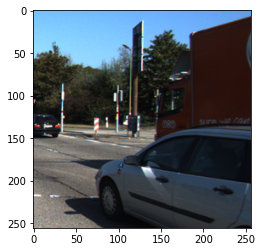

In [10]:
img_demo = plt.imread("../input/pix2pix-depth/pix2pix-depth/pix2pix-depth/training/10042010.png")
height,width,channel = img_demo.shape
print(img_demo.shape)
middle = width/2

right_img = img_demo[:,256:512,:]
left_img = img_demo[:,0:256,:]
# print(left_img.shape)

plt.imshow(left_img)

using:  -->  model_000048.h5


2022-01-11 14:20:56.851769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-11 14:20:57.865374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


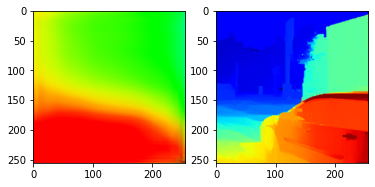

using:  -->  model_000041.h5


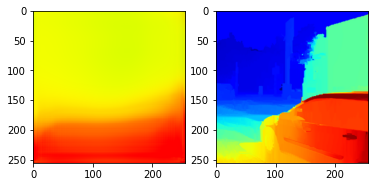

using:  -->  model_000030.h5


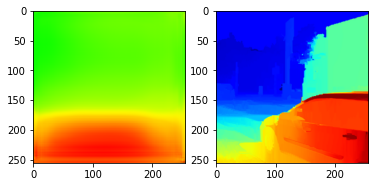

using:  -->  model_000042.h5


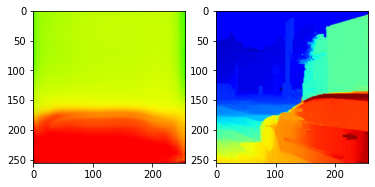

using:  -->  model_000038.h5


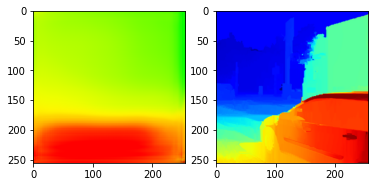

using:  -->  model_000014.h5


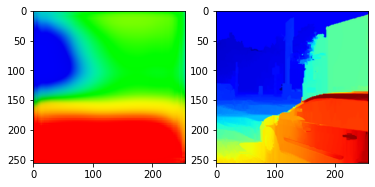

using:  -->  model_000023.h5


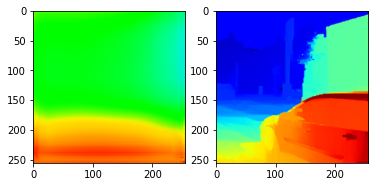

using:  -->  model_000006.h5


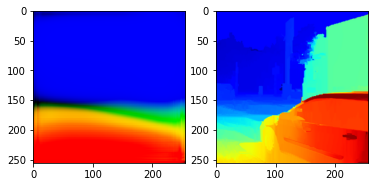

using:  -->  model_000043.h5


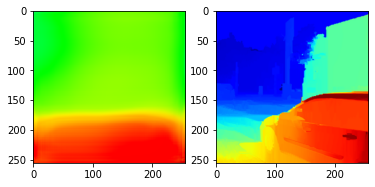

using:  -->  model_000044.h5


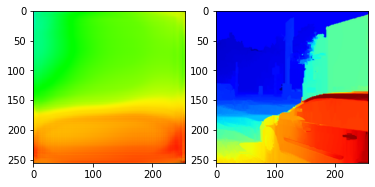

using:  -->  model_000037.h5


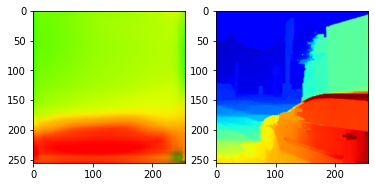

using:  -->  model_000019.h5


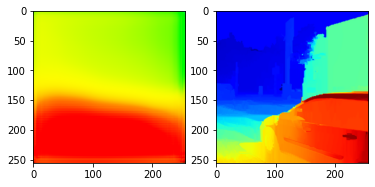

using:  -->  model_000036.h5


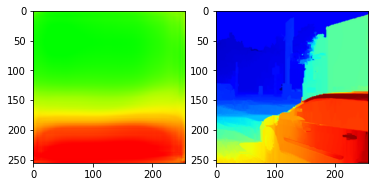

using:  -->  model_000011.h5


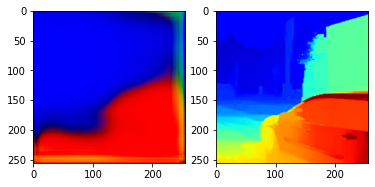

using:  -->  model_000050.h5


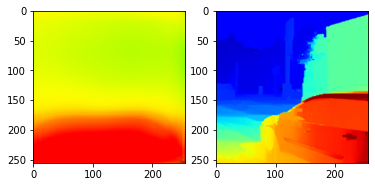

using:  -->  model_000009.h5


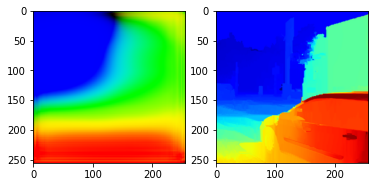

using:  -->  model_000007.h5


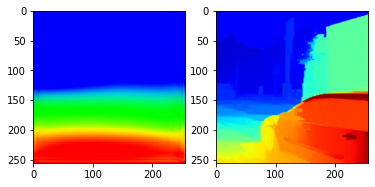

using:  -->  model_000028.h5


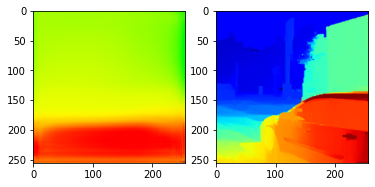

using:  -->  model_000039.h5


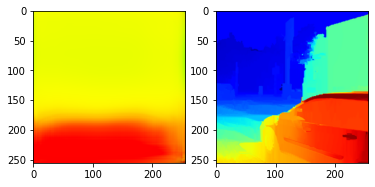

using:  -->  model_000026.h5


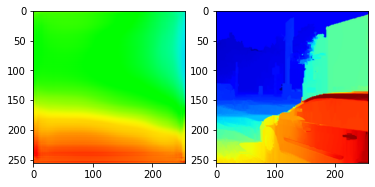

using:  -->  model_000025.h5


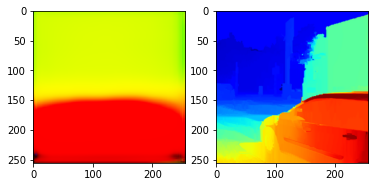

using:  -->  model_000012.h5


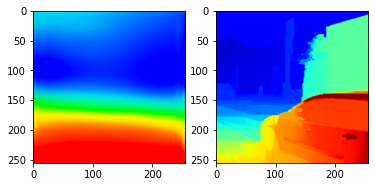

using:  -->  model_000010.h5


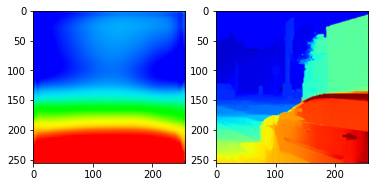

using:  -->  model_000022.h5


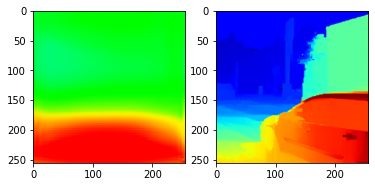

using:  -->  model_000021.h5


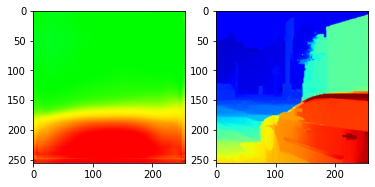

using:  -->  model_000045.h5


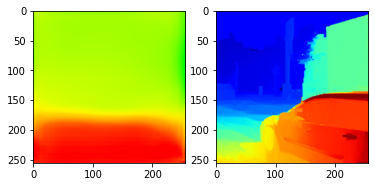

using:  -->  model_000047.h5


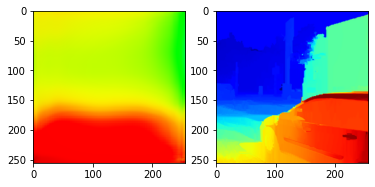

using:  -->  model_000040.h5


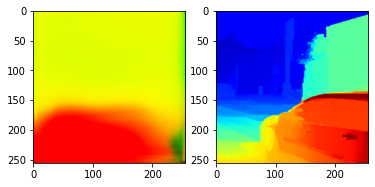

using:  -->  model_000016.h5


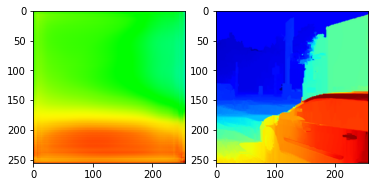

using:  -->  model_000034.h5


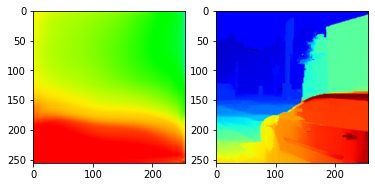

using:  -->  model_000004.h5


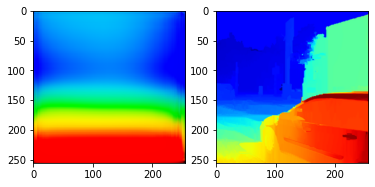

using:  -->  model_000001.h5


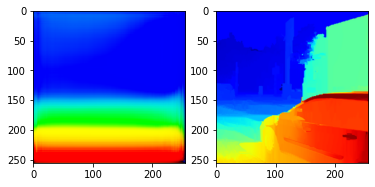

using:  -->  model_000002.h5


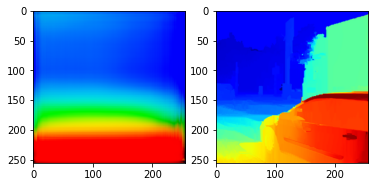

using:  -->  model_000024.h5


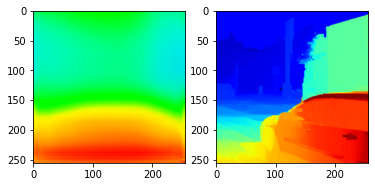

using:  -->  model_000013.h5


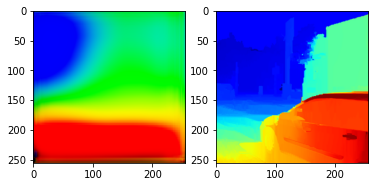

using:  -->  model_000020.h5


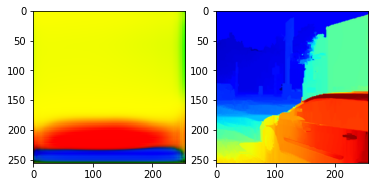

using:  -->  model_000018.h5


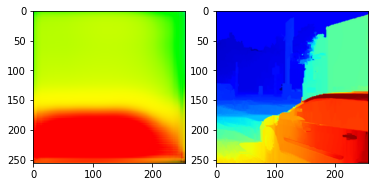

using:  -->  model_000015.h5


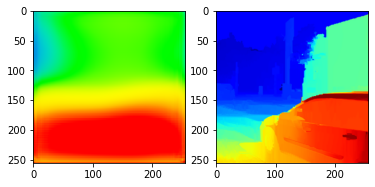

using:  -->  model_000027.h5


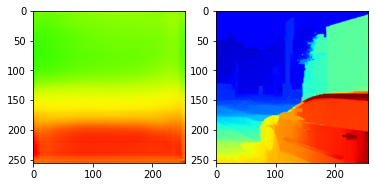

using:  -->  model_000046.h5


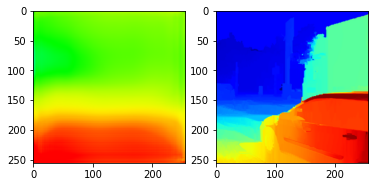

using:  -->  model_000005.h5


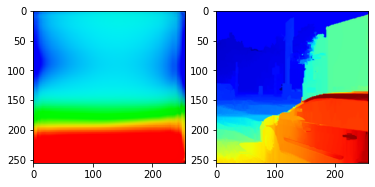

using:  -->  model_000033.h5


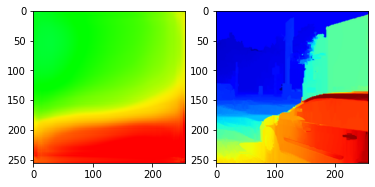

using:  -->  model_000003.h5


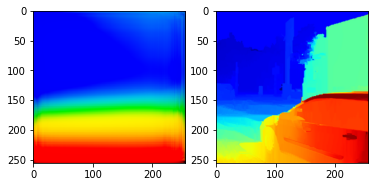

using:  -->  model_000031.h5


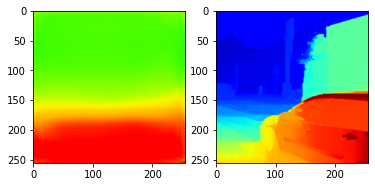

using:  -->  model_000008.h5


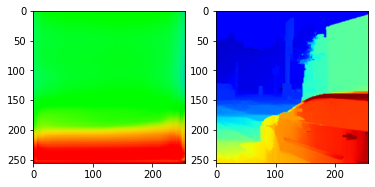

using:  -->  model_000032.h5


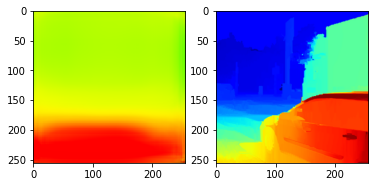

using:  -->  model_000049.h5


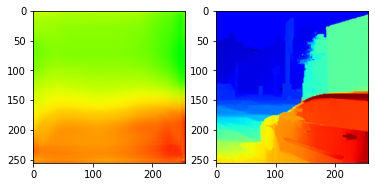

using:  -->  model_000029.h5


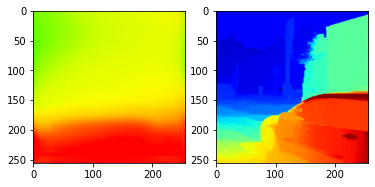

using:  -->  model_000035.h5


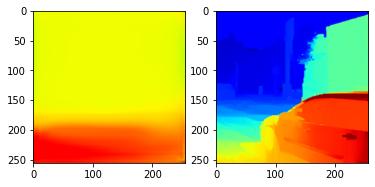

using:  -->  model_000017.h5


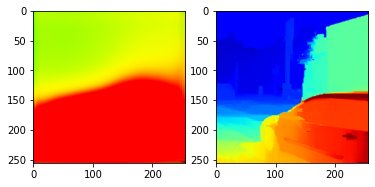

In [11]:
for i in os.listdir("../input/somu-pix2pix-depth-estimation/training_checkpoints/"):
    print(f"using:  -->  {i}")
    new_model = tf.keras.models.load_model(f'../input/somu-pix2pix-depth-estimation/training_checkpoints/{i}')

#     image_path = "../input/pix2pix-depth/pix2pix-depth/pix2pix-depth/testing_raw/0.png"
#     image = np.array(imageio.imread(image_path))
#     image = cv2.resize(image,(256,256)) 
    image = left_img
    
    image_normalized = Helpers.normalize(image)
    generated_batch = new_model.predict(np.array([image_normalized]))

    generated_batch = generated_batch.reshape((256,256,3))
#     gen_img = cv2.resize(generated_batch,(1216, 352))
    
    plt.subplot(1,2,1)
    plt.imshow(generated_batch)
    
    plt.subplot(1,2,2)
    plt.imshow(right_img)
    
    
    plt.show()

In [12]:
# plt.imread("../input/pix2pix-depth/pix2pix-depth/pix2pix-depth/testing_raw/0.png").shape